In [1]:
try:
    passes += 1
    !git pull
except:
    passes = 1
    !git clone https://github.com/arminwitte/FoolsUNet.git
    %cd FoolsUNet

Cloning into 'FoolsUNet'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 160 (delta 3), reused 2 (delta 2), pack-reused 155
Receiving objects: 100% (160/160), 27.94 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (84/84), done.
/kaggle/working/FoolsUNet


In [2]:
import tensorflow as tf

print(tf.__version__)

2024-05-26 16:01:05.417162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 16:01:05.417289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 16:01:05.525710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))

In [4]:
import tensorflow_datasets as tfds

In [5]:
dataset, info = tfds.load("imagenette/320px-v2:1.*.*", with_info=True, data_dir="./data/")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling data/imagenette/320px-v2/1.0.0.incompleteL080OX/imagenette-train.tfrecord*...:   0%|          | 0/94…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling data/imagenette/320px-v2/1.0.0.incompleteL080OX/imagenette-validation.tfrecord*...:   0%|          |…

Dataset imagenette downloaded and prepared to ./data/imagenette/320px-v2/1.0.0. Subsequent calls will reuse this data.


In [6]:
dataset

{Split('train'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 Split('validation'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [7]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [8]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (256, 256))
    input_label = datapoint["label"]

    input_image = normalize(input_image)

    return input_image, input_label

In [9]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["validation"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras import layers
class Augment(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [12]:
train_batches = (
    train_images.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

## Get pre-trained encoder and attach classification head

In [13]:
from foolsunet.model import foolsunet

In [14]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
    #base_model = tf.keras.models.load_model("foolsunet_oxfordpet.keras")
    base_model = foolsunet()
    base_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_downsample  │ (None, 128, 128,  │      1,728 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_downsample  │ (None, 64, 64,    │     74,240 │ block_1_downsamp… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_3_invres_dow… │ (None, 32, 32,    │    142,788 │ block_2_downsamp… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4_invres_dow… │ (None, 16, 16,    │    284,384 │ block_3_invres_d… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_5_invres_dow… │ (None, 8, 8, 128) │    499,206 │ block_4_invres_d… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_6_invres_dow… │ (None, 4, 4, 192) │  1,101,248 │ block_5_invres_d… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_7_upsample    │ (None, 8, 8, 128) │  1,604,480 │ block_6_invres_d… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 256) │          0 │ block_7_upsample… │
│ (Concatenate)       │                   │            │ block_5_invres_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_8_invres_ups… │ (None, 16, 16,    │    876,192 │ concatenate[0][0] │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ block_8_invres_u… │
│ (Concatenate)       │ 192)              │            │ block_4_invres_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_9_invres_ups… │ (None, 32, 32,    │    402,880 │ concatenate_1[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ block_9_invres_u… │
│ (Concatenate)       │ 128)              │            │ block_3_invres_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_10_upsample   │ (None, 64, 64,    │    147,968 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ block_10_upsampl… │
│ (Concatenate)       │ 256)              │            │ block_2_downsamp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_11_upsample   │ (None, 128, 128,  │    147,712 │ concatenate_3[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ block_11_upsampl

 Total params: 5,286,285 (20.17 MB)

 Trainable params: 5,249,393 (20.02 MB)

 Non-trainable params: 36,892 (144.11 KB)

### Define encoder

In [15]:
# Use the activations of these layers
layer_names = [
    'block_1_downsample',   # 64x64
    'block_2_downsample',   # 32x32
    'block_3_invres_downsample',   # 16x16
    'block_4_invres_downsample',  # 8x8
    'block_5_invres_downsample',      # 4x4
    'block_6_invres_downsample'
]
base_model_layers = [base_model.get_layer(name) for name in layer_names]

# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

### Define classifier

In [16]:
def assemble_model():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
#     x = base_model.input
#     x = down_stack(inputs)
    for layer in base_model_layers:
#         layer.trainable = False
        x = layer(x)
    x = tf.keras.layers.Conv2D(1024, 1, activation='relu6')(x)
    x = tf.keras.layers.AveragePooling2D(4)(x)
    x = tf.keras.layers.Conv2D(num_classes, 1, name="outputs")(x)
    x = tf.keras.layers.Flatten()(x)

    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
num_classes = 10
# classification_head = tf.keras.Sequential([
#     tf.keras.layers.Input([8,8,128]),
#     tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes, name="outputs"),])
# # classification_head.build()

In [18]:
# model = tf.keras.Sequential([base_model.get_layer(name) for name in layer_names] + [layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs"),
#                                                                                    ])
# model.build()

In [19]:
with strategy.scope():
    model = assemble_model()
    model.compile(
    optimizer="adam",
    #Anything between 2 and `steps_per_epoch` could help here.
    #steps_per_execution = 50,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
    model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_downsample (Sequential) │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_downsample (Sequential) │ (None, 64, 64, 128)    │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_invres_downsample       │ (None, 32, 32, 64)     │       142,788 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_invres_downsample       │ (None, 16, 16, 96)     │       284,384 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_invres_downsample       │ (None, 8, 8, 128)      │       499,206 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_6_invres_downsample       │ (None, 4, 4, 192)      │     1,101,248 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 4, 4, 1024)     │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 1024)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Conv2D)                │ (None, 1, 1, 10)       │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,311,476 (8.82 MB)

 Trainable params: 2,291,096 (8.74 MB)

 Non-trainable params: 20,380 (79.61 KB)

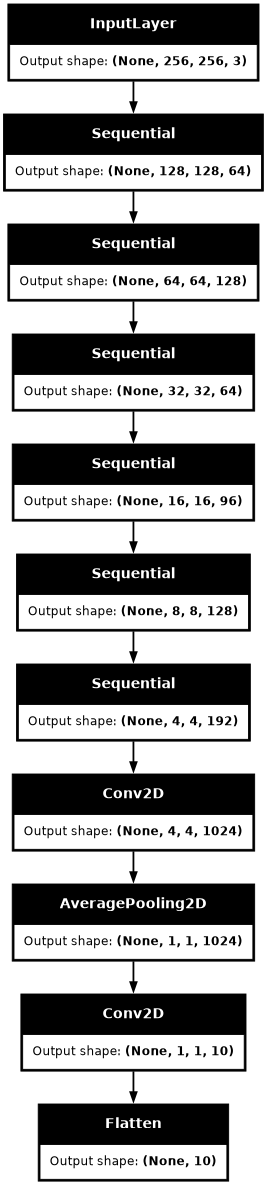

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["validation"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    # callbacks=[DisplayCallback()]
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 96s 415ms/step - accuracy: 0.3248 - loss: 1.9114 - val_accuracy: 0.1107 - val_loss: 2.6311
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 63s 405ms/step - accuracy: 0.5865 - loss: 1.2337 - val_accuracy: 0.0911 - val_loss: 3.2206
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 405ms/step - accuracy: 0.6754 - loss: 0.9766 - val_accuracy: 0.0924 - val_loss: 3.3619
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 405ms/step - accuracy: 0.7283 - loss: 0.8130 - val_accuracy: 0.1406 - val_loss: 2.9095
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 405ms/step - accuracy: 0.7660 - loss: 0.7089 - val_accuracy: 0.6862 - val_loss: 1.0270
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 404ms/step - accuracy: 0.7872 - loss: 0.6600 - val_accuracy: 0.6588 - val_loss: 1.3131
Epoch 7/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 406ms/step - accuracy: 0.8067 - loss: 0.5825 - val_accuracy: 0.5833 - val_loss: 1.6688
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 405ms/step - accuracy: 0.8313 - loss: 0.5215 - val_accuracy: 0.4648 - val_loss: 3.0053
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 404ms/step - accuracy: 0.8495 - loss: 0.4516 - val_accuracy: 0.6107 - val_loss: 2.1561
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 405ms/step - accuracy: 0.8543 - loss: 0.4375 - val_accuracy: 0.6966 - val_loss: 1.1926
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 405ms/step - accuracy: 0.8642 - loss: 0.4170 - val_accuracy: 0.7005 - val_loss: 1.2598
Epoch 12/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 58s 398ms/step - accuracy: 0.8793 - loss: 0.3571 - val_accuracy: 0.6941 - val_loss: 1.4772
Epoch 13/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 407ms/step - accuracy: 0.8827 - loss: 0.3504 - val_accuracy: 0.7148 - val_loss: 0.9721
Epoch 14/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 404ms/step - accuracy: 0.8870 - loss: 0.3205 

In [22]:
# Save the entire model as a `.keras` zip archive.
model.save("foolsunet_imagenette.keras")

In [23]:

model.save_weights("foolsunet_imagenette.weights.h5")

In [24]:
new_model = tf.keras.models.load_model("foolsunet_imagenette.keras")

# Show the model architecture
new_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_downsample (Sequential) │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_downsample (Sequential) │ (None, 64, 64, 128)    │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_invres_downsample       │ (None, 32, 32, 64)     │       142,788 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_invres_downsample       │ (None, 16, 16, 96)     │       284,384 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_invres_downsample       │ (None, 8, 8, 128)      │       499,206 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_6_invres_downsample       │ (None, 4, 4, 192)      │     1,101,248 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 4, 4, 1024)     │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 1024)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Conv2D)                │ (None, 1, 1, 10)       │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,893,670 (26.30 MB)

 Trainable params: 2,291,096 (8.74 MB)

 Non-trainable params: 20,380 (79.61 KB)

 Optimizer params: 4,582,194 (17.48 MB)